In [29]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [30]:
# specify the kilosorted data directory
kilosort_dir = r"C:\Users\smearlab\clickbait-ephys\kilosorted_data_20um_tetrode\6002\7"

# Parameters for building the spike rate matrix
fs = 30000 # Hz
window_size = 0.5 # seconds
step_size = 0.5 # seconds

In [ ]:
def compute_spike_rates_sliding_window_by_region(kilosort_dir: str, sampling_rate: int, window_size: float =1.0, step_size: float = 0.5, use_units: str = 'all'):
    """
    Computes the spike rate for OB and HC units in sliding windows.

    Parameters:
    - kilosort_dir (str): Path to the Kilosort4 output directory.
    - sampling_rate (float): Sampling rate of the recording in Hz.
    - window_size (float): Size of the sliding window in seconds.
    - step_size (float): Step size between consecutive windows in seconds.
    - use_units (str): Specify which units to include ('all', 'good', 'mua', 'good/mua').

    Returns:
    - spike_rate_matrix_OB (np.ndarray): 2D array (OB units x windows) of spike rates (Hz).
    - spike_rate_matrix_HC (np.ndarray): 2D array (HC units x windows) of spike rates (Hz).
    - time_bins (np.ndarray): Time points (seconds) corresponding to each window.
    - unit_ids_OB (np.ndarray): OB Unit IDs.
    - unit_ids_HC (np.ndarray): HC Unit IDs.
    """

    # Load spike times and cluster assignments
    spike_times_path = os.path.join(kilosort_dir, "spike_times.npy")
    spike_clusters_path = os.path.join(kilosort_dir, "spike_clusters.npy") # cluster assignments from Phy2 manual curation
    templates_path = os.path.join(kilosort_dir, "templates.npy")
    templates_ind_path = os.path.join(kilosort_dir, "templates_ind.npy")
    cluster_groups_path = os.path.join(kilosort_dir, "cluster_group.tsv")

    # Ensure all required files exist
    if not all(os.path.exists(p) for p in [spike_times_path, spike_clusters_path, templates_path, templates_ind_path, cluster_groups_path]):
        raise FileNotFoundError("Missing required Kilosort output files.")

    # Loading the data
    templates = np.load(templates_path)  # Shape: (nTemplates, nTimePoints, nChannels)
    templates_ind = np.load(templates_ind_path)  # Shape: (nTemplates, nChannels)
    spike_times = np.load(spike_times_path) / sampling_rate  # Convert to seconds
    spike_clusters = np.load(spike_clusters_path)
    cluster_groups = np.loadtxt(cluster_groups_path, dtype=str, skiprows=1, usecols=[1])


    # Find peak amplitude channel for each template and assign to unit
    peak_channels = np.argmax(np.max(np.abs(templates), axis=1), axis=1)
    unit_best_channels = {unit: templates_ind[unit, peak_channels[unit]] for unit in range(len(peak_channels))}
    
    # Filter units based on use_units parameter
    if use_units == 'all':
        unit_best_channels = unit_best_channels
    elif use_units == 'good':
        unit_indices = np.where(cluster_groups == 'good')[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}
    elif use_units == 'mua':
        unit_indices = np.where(cluster_groups == 'mua')[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}
    elif use_units == 'good/mua':
        unit_indices = np.where(np.isin(cluster_groups, ['good', 'mua']))[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}
    elif use_units == 'noise':
        unit_indices = np.where(cluster_groups == 'noise')[0]
        unit_best_channels = {unit: unit_best_channels[unit] for unit in unit_indices}

    # Get total duration of the recording
    recording_duration = np.max(spike_times)

    # Define time windows
    time_bins = np.arange(0, recording_duration - window_size, step_size)
    num_windows = len(time_bins)

    # Separate OB and HC units
    hc_units = np.array([unit for unit, ch in unit_best_channels.items() if ch in range(0, 16)])
    ob_units = np.array([unit for unit, ch in unit_best_channels.items() if ch in range(16, 32)])
    num_ob_units = len(ob_units)
    num_hc_units = len(hc_units)

    # Initialize spike rate matrices
    spike_rate_matrix_OB = np.zeros((num_ob_units, num_windows))
    spike_rate_matrix_HC = np.zeros((num_hc_units, num_windows))

    # Compute spike counts in each window
    for i, t_start in tqdm(enumerate(time_bins), total=num_windows, desc="Computing spike rates"):
        t_end = t_start + window_size

        # Find spikes in this window
        in_window = (spike_times >= t_start) & (spike_times < t_end)
        spike_clusters_in_window = spike_clusters[in_window]

        # Compute spike rates for OB
        for j, unit in enumerate(ob_units):
            spike_rate_matrix_OB[j, i] = np.sum(spike_clusters_in_window == unit) / window_size  # Hz

        # Compute spike rates for HC
        for j, unit in enumerate(hc_units):
            spike_rate_matrix_HC[j, i] = np.sum(spike_clusters_in_window == unit) / window_size  # Hz

    return spike_rate_matrix_OB, spike_rate_matrix_HC, time_bins, ob_units, hc_units

In [ ]:
rates_OB, rates_HC, time_bins, ob_units, hc_units = compute_spike_rates_sliding_window_by_region(kilosort_dir, fs, window_size, step_size, use_units='good/mua')
print(f"OB units: {ob_units}\nHC units: {hc_units}")

Computing spike rates:   0%|          | 0/3724 [00:00<?, ?it/s]

Computing spike rates: 100%|██████████| 3724/3724 [00:12<00:00, 286.96it/s]

OB units: []
HC units: []


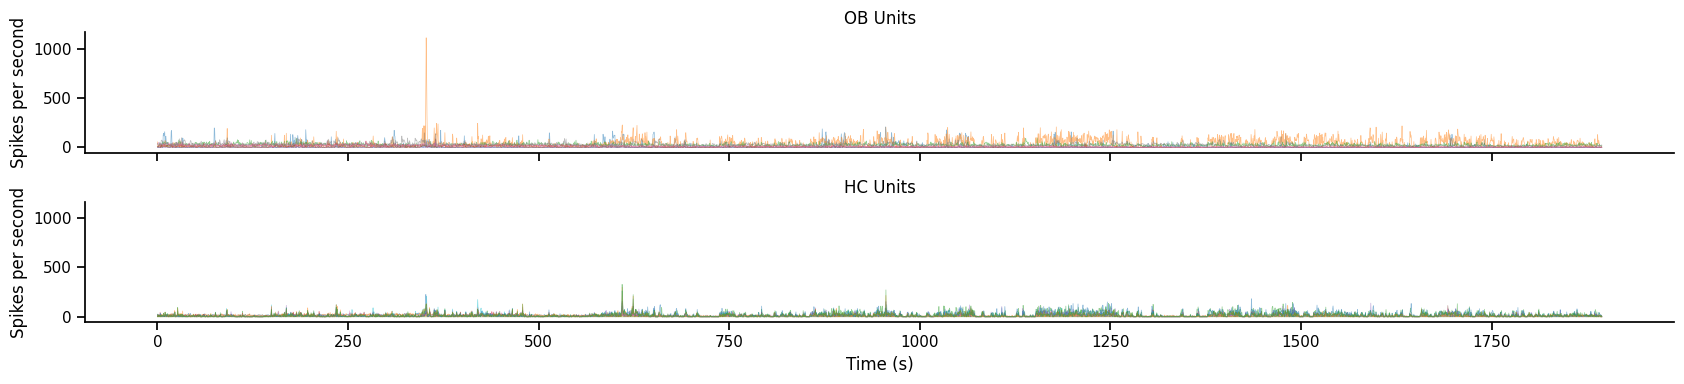

In [21]:
# Plotting the spike rates
fig, axs = plt.subplots(2, 1, figsize=(17, 4), sharex=True, sharey=True)
for j, region in enumerate([("OB", rates_OB, ob_units), ("HC", rates_HC, hc_units)]):
    region_name, rates, units = region
    num_units = rates.shape[0]

    for i in range(num_units):
        axs[j].plot(time_bins, rates[i], label=f"Unit {units[i]}", alpha=0.5, linewidth=0.5)
    axs[j].set_ylabel("Spikes per second")
    axs[j].set_title(f"{region_name} Units")
    sns.despine(ax=axs[j])

axs[1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [22]:
from scipy.io import loadmat

def load_sniff_MATLAB(file: str) -> np.array:
    '''
    Loads a MATLAB file containing sniff data and returns a numpy array
    '''

    mat = loadmat(file)
    sniff_params = mat['sniff_params']

    # loading sniff parameters
    inhalation_times = sniff_params[:, 0]
    inhalation_voltage = sniff_params[:, 1]
    exhalation_times = sniff_params[:, 2]
    exhalation_voltage = sniff_params[:, 3]

    # bad sniffs are indicated by 0 value in exhalation_times
    bad_indices = np.where(exhalation_times == 0)


    # removing bad sniffs
    inhalation_times = np.delete(inhalation_times, bad_indices)
    inhalation_voltage = np.delete(inhalation_voltage, bad_indices)
    exhalation_times = np.delete(exhalation_times, bad_indices)
    exhalation_voltage = np.delete(exhalation_voltage, bad_indices)

    return inhalation_times.astype(np.int32), inhalation_voltage, exhalation_times.astype(np.int32), exhalation_voltage

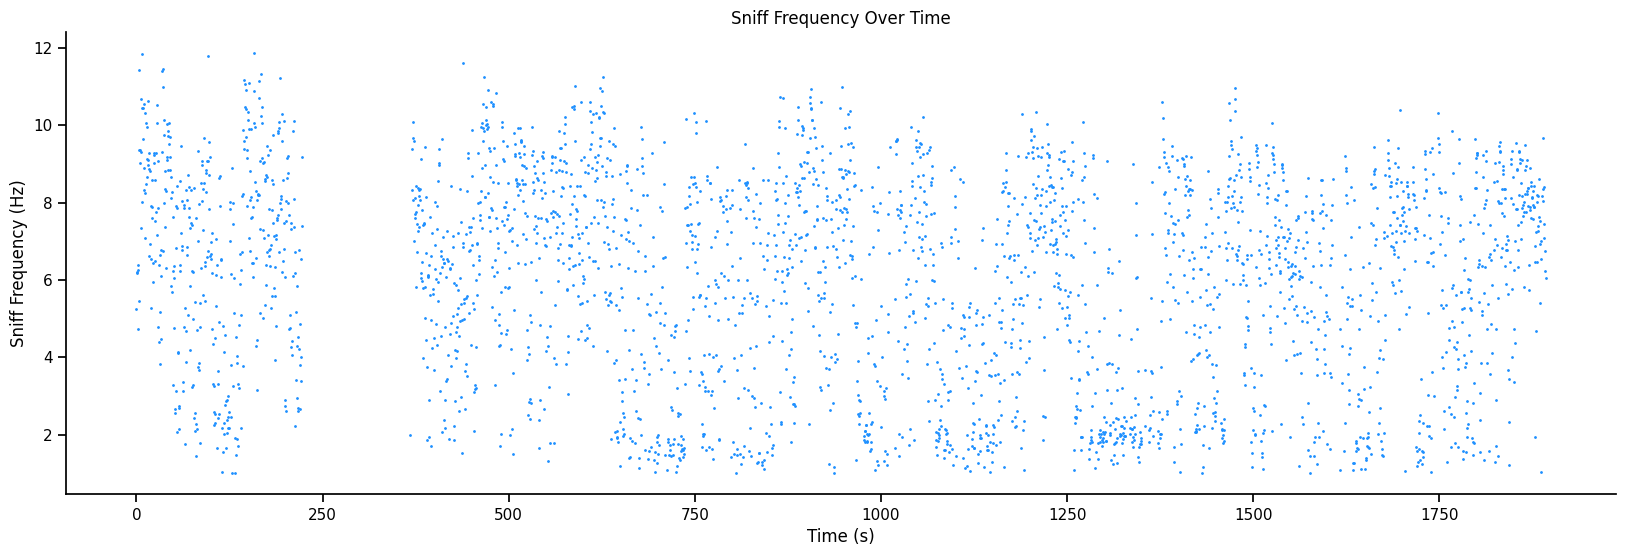

In [23]:
# Load sniff data
sniff_params_file = r"C:\Users\smearlab\clickbait-ephys\data\sniff_data\6000\0\sniff_params.mat"
sfs = 1_000  # Define sampling rate for sniff

inhalation_times, _, _, _ = load_sniff_MATLAB(sniff_params_file)
inhalation_times = inhalation_times / sfs  # Convert to seconds

# Compute sniff frequencies
freqs = 1 / np.diff(inhalation_times) # Compute frequencies

# Remove unrealistic frequencies
bad_indices = np.where((freqs > 16) | (freqs < 1))[0]  # Fixed OR condition
freqs = np.delete(freqs, bad_indices)
inhalation_times = np.delete(inhalation_times[:-1], bad_indices)  # Fix slicing

# Compute mean sniff frequency in each time bin
mean_freqs = np.full(len(time_bins), np.nan)  # Initialize with NaNs
inhalation_latencies = np.full(len(time_bins), np.nan)  # Initialize with NaNs

for i, t_start in enumerate(time_bins):
    t_end = t_start + window_size
    middle = t_start + window_size / 2
    in_window = (inhalation_times >= t_start) & (inhalation_times < t_end)
    
    # computing the latency of the middle of the time bin from the last inhalation time
    last_inh_time = inhalation_times[inhalation_times < middle][-1] if np.any(inhalation_times < middle) else np.nan
    inhalation_latencies[i] = middle - last_inh_time

    
    if np.any(in_window):  # Ensure there are valid inhalation times
        mean_freqs[i] = np.nanmean(freqs[in_window])  # Avoid NaN issues

# Plot sniff frequencies
plt.figure(figsize=(20, 6))
plt.scatter(time_bins, mean_freqs, label="Mean Sniff Frequency", s=1, color='dodgerblue')
plt.ylabel("Sniff Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Sniff Frequency Over Time")
sns.despine()
plt.show()

In [24]:
# dimensionality reduction
import umap
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# defining the UMAP reducer
reducer = umap.UMAP()

# converting the spike rate matrix to a DataFrame
OB_data = pd.DataFrame(rates_OB.T, columns=[f"Unit {i}" for i in ob_units])
OB_data['sn/s'] = mean_freqs
OB_data['latency'] = inhalation_latencies
#set latencies to nan if they are greater than 1 s
OB_data.loc[OB_data['latency'] > 1, 'latency'] = np.nan

# interpolate missing values
OB_data['sn/s'] = OB_data['sn/s'].interpolate(method='linear')

print(OB_data[100:110])

# scaling the data
scaled_OB_data = StandardScaler().fit_transform(OB_data.drop(columns=['sn/s', 'latency']))

# fitting the UMAP model and transforming the data
embedding_OB = reducer.fit_transform(scaled_OB_data)



     Unit 0  Unit 1  Unit 6  Unit 7  Unit 9  Unit 10  Unit 11  Unit 12  \
100     2.0    22.0    52.0    14.0     0.0      6.0     14.0     34.0   
101     0.0    18.0    36.0     6.0     2.0      2.0     34.0     34.0   
102     0.0     2.0    50.0    14.0     2.0      2.0     20.0     28.0   
103     2.0     0.0    40.0     4.0     4.0      6.0     18.0     22.0   
104     0.0     0.0    44.0    12.0     6.0      0.0     16.0     38.0   
105     2.0     0.0    20.0    22.0     0.0      4.0     36.0     32.0   
106     0.0    16.0    16.0    20.0     4.0      8.0     28.0     30.0   
107     0.0     8.0    38.0     8.0     2.0     10.0     12.0     32.0   
108     0.0     4.0    12.0    12.0     2.0      8.0     22.0     40.0   
109     0.0    10.0    36.0    18.0     6.0      6.0     16.0     24.0   

         sn/s  latency  
100  6.040358    0.095  
101  6.372875    0.026  
102  4.750845    0.078  
103  2.564103    0.578  
104  2.659574    0.096  
105  3.123582    0.220  
106  6.832

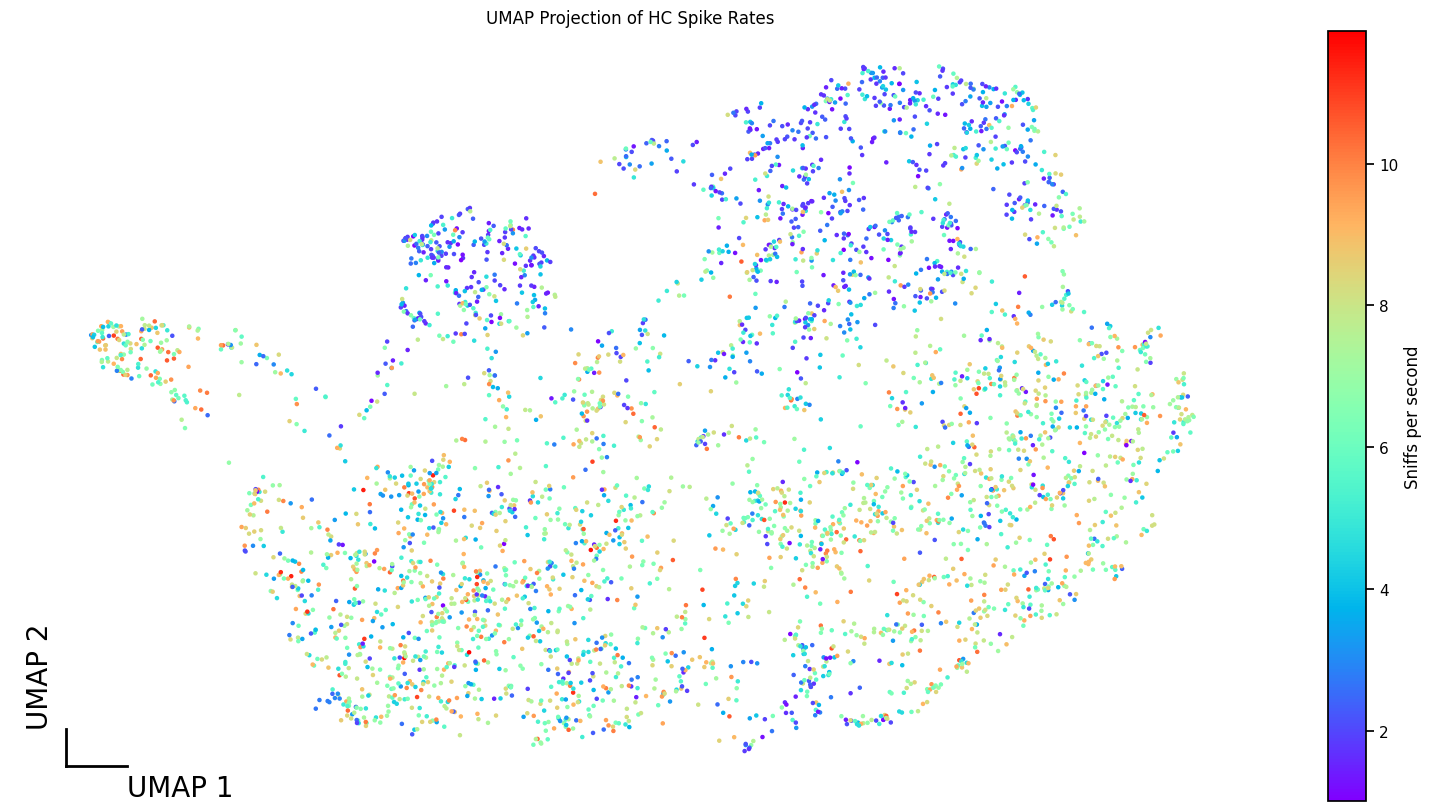

In [25]:

# Set context for large plots
sns.set_context('notebook')

# Create figure
plt.figure(figsize=(20, 10))

# Scatter plot with sniff frequency color coding
sc = plt.scatter(embedding_OB[:, 0], embedding_OB[:, 1], c=OB_data['sn/s'], cmap='rainbow', s=5)
plt.colorbar(label="Sniffs per second")

# Remove full axes
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add a small L-shaped axis in bottom-left
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Define small axis length relative to plot
axis_length_x = (x_max - x_min) * 0.05  # 5% of plot width
axis_length_y = (y_max - y_min) * 0.05  # 5% of plot height

# Bottom-left corner of the axis
axis_x_start = x_min + axis_length_x * 0.5
axis_y_start = y_min + axis_length_y * 0.5

# Draw small L-shaped axis
plt.plot([axis_x_start, axis_x_start + axis_length_x], [axis_y_start, axis_y_start], 'k', linewidth=2)  # X-axis segment
plt.plot([axis_x_start, axis_x_start], [axis_y_start, axis_y_start + axis_length_y], 'k', linewidth=2)  # Y-axis segment

# Add axis labels near the small L-shaped axis
plt.annotate("UMAP 1", (axis_x_start + axis_length_x, axis_y_start - 0.01 * (y_max - y_min)), fontsize=20, ha='left', va='top')
plt.annotate("UMAP 2", (axis_x_start - 0.01 * (x_max - x_min), axis_y_start + axis_length_y), fontsize=20, ha='right', va='bottom', rotation=90)

# Title
plt.title("UMAP Projection of HC Spike Rates")

# Show plot
plt.show()






HC


In [27]:
# defining the UMAP reducer
reducer = umap.UMAP()

# converting the spike rate matrix to a DataFrame
OB_data = pd.DataFrame(rates_HC.T, columns=[f"Unit {i}" for i in hc_units])
OB_data['sn/s'] = mean_freqs
OB_data['latency'] = inhalation_latencies
# interpolate missing values
OB_data['sn/s'] = OB_data['sn/s'].interpolate(method='linear')

#set latencies to nan if they are greater than 1 s
OB_data.loc[OB_data['latency'] > 1, 'latency'] = np.nan

print(OB_data[100:110])

# scaling the data
scaled_OB_data = StandardScaler().fit_transform(OB_data.drop(columns=['sn/s', 'latency']))

# fitting the UMAP model and transforming the data
embedding_HC = reducer.fit_transform(scaled_OB_data)

     Unit 13  Unit 15  Unit 17  Unit 18  Unit 19  Unit 20  Unit 21  Unit 23  \
100     20.0     22.0      4.0     14.0      0.0      4.0      0.0      0.0   
101     12.0     12.0     16.0     28.0      0.0      0.0      6.0      0.0   
102      8.0     20.0      4.0     10.0      6.0      0.0      0.0      0.0   
103      6.0      6.0     10.0      4.0      0.0      0.0      0.0      0.0   
104     10.0      6.0     12.0     12.0      0.0      2.0      0.0      0.0   
105     18.0     16.0     12.0     10.0      0.0      2.0      0.0      0.0   
106     12.0     18.0      6.0     24.0      6.0      6.0      8.0      0.0   
107     26.0     20.0      8.0      4.0      2.0      4.0      4.0      0.0   
108      4.0     10.0      4.0      4.0      2.0      2.0      4.0      0.0   
109     10.0      8.0      6.0     16.0     14.0      2.0      4.0      0.0   

     Unit 24  Unit 25  Unit 26  Unit 27  Unit 28      sn/s  latency  
100      0.0      4.0      6.0      8.0      8.0  6.040358  

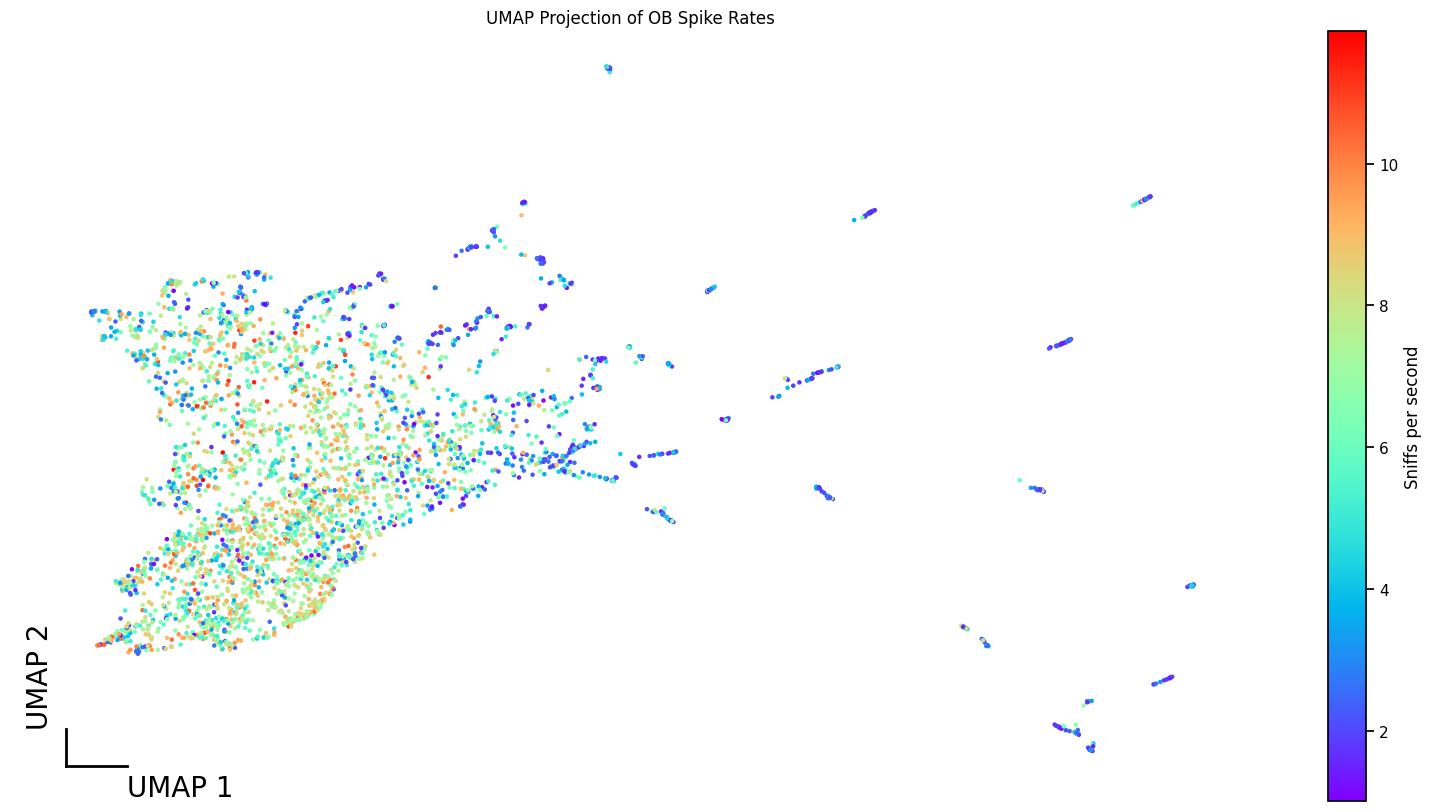

In [28]:
# Set context for large plots
sns.set_context('notebook')

# Create figure
plt.figure(figsize=(20, 10))

# Scatter plot with sniff frequency color coding
sc = plt.scatter(embedding_HC[:, 0], embedding_HC[:, 1], c=OB_data['sn/s'], cmap='rainbow', s=5)
plt.colorbar(label="Sniffs per second")

# Remove full axes
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add a small L-shaped axis in bottom-left
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Define small axis length relative to plot
axis_length_x = (x_max - x_min) * 0.05  # 5% of plot width
axis_length_y = (y_max - y_min) * 0.05  # 5% of plot height

# Bottom-left corner of the axis
axis_x_start = x_min + axis_length_x * 0.5
axis_y_start = y_min + axis_length_y * 0.5

# Draw small L-shaped axis
plt.plot([axis_x_start, axis_x_start + axis_length_x], [axis_y_start, axis_y_start], 'k', linewidth=2)  # X-axis segment
plt.plot([axis_x_start, axis_x_start], [axis_y_start, axis_y_start + axis_length_y], 'k', linewidth=2)  # Y-axis segment

# Add axis labels near the small L-shaped axis
plt.annotate("UMAP 1", (axis_x_start + axis_length_x, axis_y_start - 0.01 * (y_max - y_min)), fontsize=20, ha='left', va='top')
plt.annotate("UMAP 2", (axis_x_start - 0.01 * (x_max - x_min), axis_y_start + axis_length_y), fontsize=20, ha='right', va='bottom', rotation=90)

# Title
plt.title("UMAP Projection of OB Spike Rates")

# Show plot
plt.show()